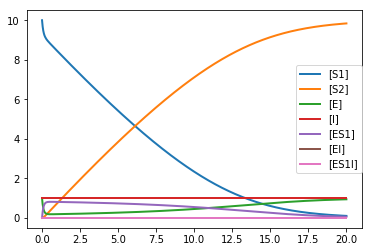

In [44]:
# example-3: enzyme with inhibitor
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt

te.setDefaultPlottingEngine('matplotlib')

modelA = """
model test
    compartment C1;
    C1 = 1.0;
    species S1, S2, E, I, ES1, EI, ES1I;

    S1 = 10.0;
    S2 = 0.0;
    E = 1.0;
    I = 1.0;
    ES1 = 0.0;
    EI = 0.0;
    ES1I = 0.0;
    
    S1 in C1; S2 in C1; E in C1; I in C1; ES1 in C1; EI in C1; ES1I in C1;
    J1: S1 + E -> ES1; S1*E*kfs1;  # substrate association
    J2: ES1 -> S1 + E; ES1*krs1;  # substrate dissociation
    J3: ES1 -> S2 + E; ES1*kc;   #catalytic
    J4: I + E -> EI; I*E*kfi1; #inhibitor association
    J5: EI -> E + I; EI*kri1;  #inhibitor dissociation
    J6: ES1 + I -> ES1I; ES1*I*kfi2; #inhibitor association to complex
    J7: EI + S1 -> ES1I; EI*S1*kfs2; #substrate association to complex
    J8: ES1I -> ES1 + I; ES1I*kri2; #inhibitor dissociation from complex
    J9: ES1I -> EI + S1; ES1I*krs2; #substrate dissociation from complex
    J10: ES1I -> EI + S2; ES1I*kci; #catalytic with substrate

    kfs1 = 1.0; krs1 = 1.0; 
    kfi1 = 0.0; kri1 = 1.0;
    kfi2 = 0.0; kri2 = 1.0;
    kfs2 = 1.0; krs2 = 1.0;
    kc = 1.0; kci = 1.0;
end
"""
# load models
rDefault = te.loada(modelA)


# simulate from 0 to 50 with 100 steps
rDefault.simulate(0, 20, 500)
# plot the simulation
rDefault.plot()

In [45]:
# parameter scan simulation 
def paramScan(param, paramRange, r, prod, Tmax):
    r.reset() # re-seting simulation result
    m = r.simulate (0, Tmax, 5*Tmax, selections=["time"]) #make time array
    for i in range(0,len(paramRange)):
        r.reset()
        r[param] = paramRange[i]
        res = r.simulate(0, Tmax, 5*Tmax, selections=[prod])
        m = np.concatenate([m, res], axis=1)
    return m 

# initial velocity estimation
def initV(simResult):
    initM = simResult[0, 1:]  # initial product [S2]
    finalM = simResult[-1,1:] # final product [S2]
    timecourseM = simResult[:,1:] # timecourse [S2]
    
    #find the differences between 1/2 [S2]max and each timcourse [S2] 
    #the minimal absolute difference would be where [S2] ~ 1/2 [S2]max
    diffMmid = abs(timecourseM-(finalM/2)) 
    # find that minimum difference values
    minInColumns = np.amin(diffMmid, axis=0)
    # find the index where where [S2] ~ 1/2 [S2]max
    ind = np.where(minInColumns == diffMmid)[0] # index of mid time
    timepoint = simResult[:, 0] # time point array from time course simulation 
    thalf = timepoint[ind] # time point when [S2] ~ 1/2 [S2]max
    
    # estimate initial reaction velocity
    Vinit = ((finalM/2) - initM) / thalf
    
    return Vinit

def lineweaverBurk(Vinit, Sinit):
    inv_S1 = np.power(S1range,-1) # calculate 1/[S1]
    inv_Vinit = np.power(Vinit,-1) # calculate 1/[Vinit]
    
    # Linear Regression Curve Fitting
    # https://data36.com/linear-regression-in-python-numpy-polyfit/ 
    model = np.polyfit(inv_S1, inv_Vinit, 1)
    predict = np.poly1d(model)
    x_lin_reg = np.linspace(-max(inv_S1), max(inv_S1), 10)
    y_lin_reg = predict(x_lin_reg)
    
    return inv_S1, inv_Vinit, model, x_lin_reg, y_lin_reg

def plotArray(simResult, ylab):
    time = simResult[:, 0] # time points
    N = len(simResult[0,:]) -1 # number of simulation timecourses
    for i in range(0,N):
        plt.plot(time,simResult[:, i+1])
    plt.xlabel("time", fontsize=16)
    plt.xticks(fontsize=12)
    plt.ylabel(ylab, fontsize=16)
    plt.yticks(fontsize=12)

(-26.879999999968625, 537.5999999993725)

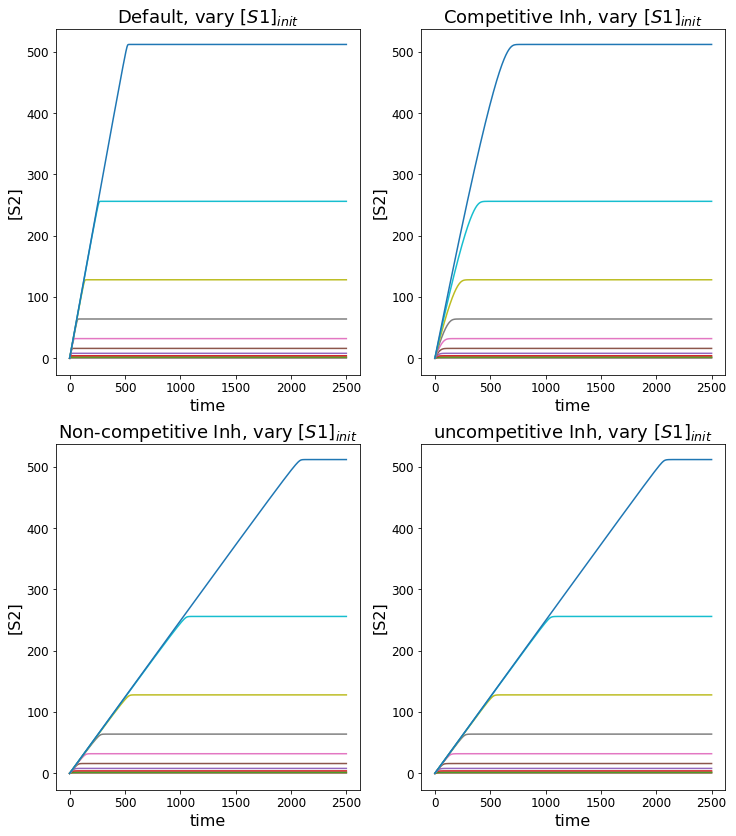

In [46]:
runTime = 2500

# Try varying S1 initial 
S1range = [0.5,1, 2, 4, 8, 16, 32, 64, 128, 256, 512] # range of 

########################
# default simulation
r = te.loada(modelA)
m1 = paramScan('[S1]', S1range, r, 'S2', runTime)
#+++++

## competitive inhibition
r2 = te.loada(modelA)
r2.kfi1 = 30 ## inhibitor binding constant to free enzyme
r2.kfs2 = 0
m2 = paramScan('[S1]', S1range, r2, 'S2', runTime)
#+++++

# non-competitive inhibition
r3 = te.loada(modelA)
r3.kfi1 = 30 ## inhibitor binding constant to free enzyme
r3.kfi2 = 30 ## inhibitor binding constant to complex
r3.kci = 0.1 # catalytic rate in the presence of inhibitor binding 
m3 = paramScan('[S1]', S1range, r3, 'S2', runTime)
#+++++++

# uncompetitive inhibition
r4 = te.loada(modelA)
r4.kfi1 = 0 ## inhibitor binding constant to free enzyme
r4.kfi2 = 30 ## inhibitor binding constant to complex
r4.kci = 0.1 # catalytic rate in the presence of inhibitor binding 
m4 = paramScan('[S1]', S1range, r4, 'S2', runTime)

########################
# find maximal range for Y axis
maxm1 = max(m1[:,1:].flatten())
maxm2 = max(m2[:,1:].flatten())
maxm3 = max(m3[:,1:].flatten())
maxm4 = max(m4[:,1:].flatten())
ybound = max([maxm1,maxm2, maxm3, maxm4])*1.05

# set figure size
plt.subplots(figsize=(12,14 )) 
### generate plots 
# default
plt.subplot(2,2,1)
plotArray(m1, "[S2]")
plt.title("Default, vary $[S1]_{init}$", fontsize=18)
plt.ylim(-ybound/20, ybound)
#+++++

### competitive inhibition
plt.subplot(2,2,2)
plotArray(m2, "[S2]")
plt.title("Competitive Inh, vary $[S1]_{init}$", fontsize=18)
plt.ylim(-ybound/20, ybound)
#+++++

### non-competitive inhibition
plt.subplot(2,2,3)
plotArray(m3, "[S2]")
plt.title("Non-competitive Inh, vary $[S1]_{init}$", fontsize=18)
plt.ylim(-ybound/20, ybound)
#+++++

### uncompetitive inhibition
plt.subplot(2,2,4)
plotArray(m4, "[S2]")
plt.title("uncompetitive Inh, vary $[S1]_{init}$", fontsize=18)
plt.ylim(-ybound/20, ybound)


Default:
Vmax = 1.072347168974679
Km = 4.6170645296127315
Competitive:
Vmax = 0.5714493183499626
Km = 10.612538973511814
Non-competitive:
Vmax = 0.26646311230474407
Km = 3.389541006849223
Uncompetitive:
Vmax = 0.2993817456131017
Km = 5.23715750994698


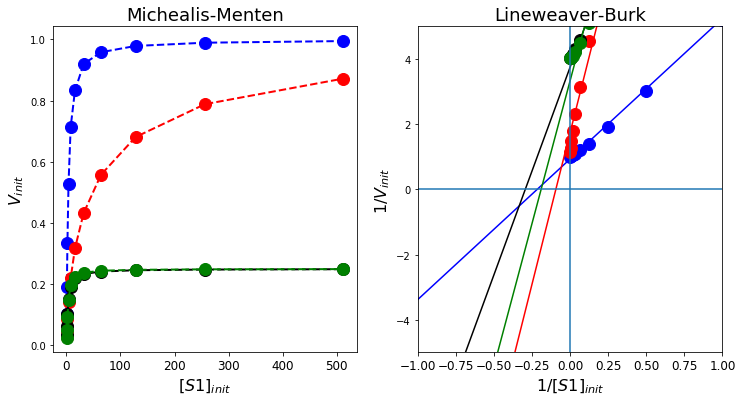

In [48]:
# Michealis-Menten
Vinit1 = initV(m1)
Vinit2 = initV(m2)
Vinit3 = initV(m3)
Vinit4 = initV(m4)

### Lineweaver-Burk
inv_S1, inv_Vinit1, model, x_lin_reg, y_lin_reg = lineweaverBurk(Vinit1, S1range)
inv_S12, inv_Vinit2, model2, x_lin_reg2, y_lin_reg2 = lineweaverBurk(Vinit2, S1range)
inv_S13, inv_Vinit3, model3, x_lin_reg3, y_lin_reg3 = lineweaverBurk(Vinit3, S1range)
inv_S14, inv_Vinit4, model4, x_lin_reg4, y_lin_reg4 = lineweaverBurk(Vinit4, S1range)



### Print out Vmax & Km
print("Default:")
print("Vmax = " + str(np.power(model[1], -1)))
print("Km = " + str(model[0]/model[1]))
print("Competitive:")
print("Vmax = " + str(np.power(model2[1], -1)))
print("Km = " + str(model2[0]/model2[1]))
print("Non-competitive:")
print("Vmax = " + str(np.power(model3[1], -1)))
print("Km = " + str(model3[0]/model3[1]))
print("Uncompetitive:")
print("Vmax = " + str(np.power(model4[1], -1)))
print("Km = " + str(model4[0]/model4[1]))



# comparing result from the two simulation
# Michealis-Menten
plt.subplots(figsize=(12,6 )) # set figure size
plt.subplot(1,2,1)

plt.plot(S1range, Vinit1, marker='o', linestyle='dashed', color = 'b',
              linewidth=2, markersize=12)

plt.plot(S1range, Vinit2, marker='o', linestyle='dashed', color = 'r',
              linewidth=2, markersize=12)

plt.plot(S1range, Vinit3, marker='o', linestyle='dashed', color = 'k',
              linewidth=2, markersize=12)

plt.plot(S1range, Vinit4, marker='o', linestyle='dashed', color = 'g',
              linewidth=2, markersize=12)

plt.xlabel("$[S1]_{init}$", fontsize=16)
plt.ylabel("$V_{init}$", fontsize=16)
plt.title("Michealis-Menten", fontsize=18)
plt.xticks(fontsize=12)
#plt.xlim((-5,1500))


# Lineweaver-Burk
plt.subplot(1,2,2)

plt.plot(inv_S1, inv_Vinit1, marker='o', linestyle="none", color = 'b',
               markersize=12)
plt.plot(x_lin_reg, y_lin_reg, c = 'b')

plt.plot(inv_S12, inv_Vinit2, marker='o', linestyle="none", color = 'r',
               markersize=12)
plt.plot(x_lin_reg2, y_lin_reg2, c = 'r')

plt.plot(inv_S13, inv_Vinit3, marker='o', linestyle="none", color = 'k',
               markersize=12)
plt.plot(x_lin_reg3, y_lin_reg3, c = 'k')

plt.plot(inv_S14, inv_Vinit4, marker='o', linestyle="none", color = 'g',
               markersize=12)
plt.plot(x_lin_reg4, y_lin_reg4, c = 'g')



plt.xlabel("1/$[S1]_{init}$", fontsize=16)
plt.ylabel("1/$V_{init}$", fontsize=16)
plt.title("Lineweaver-Burk", fontsize=18)
plt.xticks(fontsize=12)
plt.xlim((-1,1)) # set x-axis range
plt.ylim((-5,5)) # set y-axis range
plt.axvline(x=0) # vertical line at x-axis
plt.axhline(y=0) # horizontal line at y-axis